<a href="https://colab.research.google.com/github/TejasviBaddam/Automated-Detection-of-Diabetic-Retinopathy-Using-Convolutional-Neural-Networks-CNN-/blob/main/Data_V1_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import shutil
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import cv2

In [3]:
dataset_path = "/content/drive/MyDrive/dataset/binary_dataset"

def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(img_path).resize((224, 224))
            img = np.array(img)
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images), np.array(labels)

healthy_folder = os.path.join(dataset_path, "healthy")
healthy_images, healthy_labels = load_images_from_folder(healthy_folder, label=0)

non_healthy_folder = os.path.join(dataset_path, "non_healthy")
non_healthy_images, non_healthy_labels = load_images_from_folder(non_healthy_folder, label=1)

X = np.concatenate((healthy_images, non_healthy_images), axis=0)
y = np.concatenate((healthy_labels, non_healthy_labels), axis=0)

print(f"Total images loaded: {X.shape[0]}")
print(f"Healthy images: {healthy_images.shape[0]}")
print(f"Non-healthy images: {non_healthy_images.shape[0]}")

Total images loaded: 3662
Healthy images: 1805
Non-healthy images: 1857


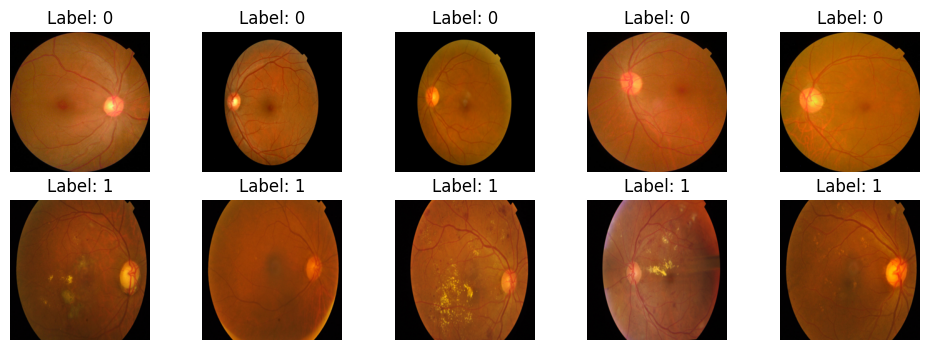

In [4]:
def show_sample_images(images, labels, num_images_per_label=5):
    unique_labels = np.unique(labels)

    plt.figure(figsize=(12, 2 * len(unique_labels)))

    for label_index, label in enumerate(unique_labels):
        label_indices = np.where(labels == label)[0]
        label_images = images[label_indices]
        label_labels = labels[label_indices]

        for i in range(num_images_per_label):
            plt.subplot(len(unique_labels), num_images_per_label, label_index * num_images_per_label + i + 1)  # Calculate subplot position
            plt.imshow(label_images[i])
            plt.title(f"Label: {label_labels[i]}")
            plt.axis('off')

    plt.show()

show_sample_images(X, y, num_images_per_label=5)

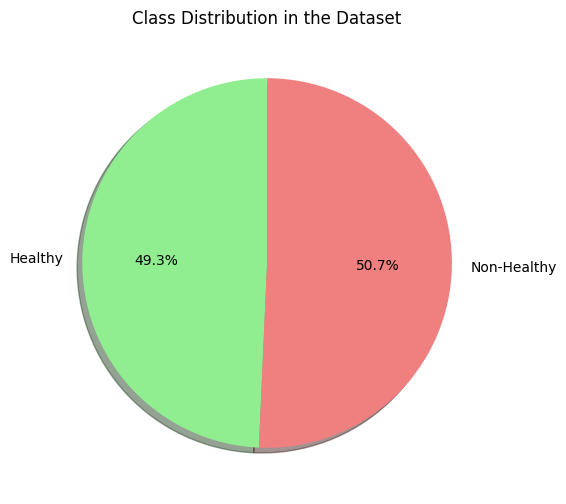

In [5]:
import matplotlib.pyplot as plt

healthy_count = np.sum(y == 0)
non_healthy_count = np.sum(y == 1)

labels = ['Healthy', 'Non-Healthy']

sizes = [healthy_count, non_healthy_count]

colors = ['lightgreen', 'lightcoral']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Class Distribution in the Dataset')
plt.show()

In [6]:
def apply_clahe(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    clahe_image = clahe.apply(gray_image)

    clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)

    return clahe_image

X_clahe = np.array([apply_clahe(image) for image in X])

print(f"Shape of CLAHE-processed dataset: {X_clahe.shape}")

Shape of CLAHE-processed dataset: (3662, 224, 224, 3)


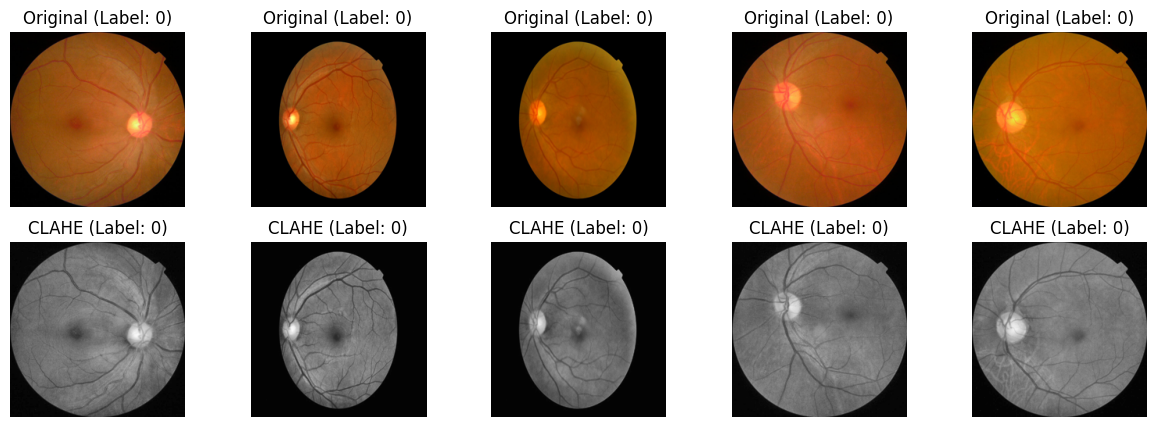

In [7]:
def show_original_vs_clahe(original_images, clahe_images, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i+1)
        plt.imshow(original_images[i])
        plt.title(f"Original (Label: {y[i]})")
        plt.axis('off')

        plt.subplot(2, num_images, i+num_images+1)
        plt.imshow(clahe_images[i])
        plt.title(f"CLAHE (Label: {y[i]})")
        plt.axis('off')
    plt.show()

show_original_vs_clahe(X, X_clahe, num_images=5)

In [8]:
# Save the CLAHE-processed dataset
np.save("/content/drive/MyDrive/dataset/X_clahe.npy", X_clahe)

In [9]:
# Normalize pixel values to [0, 1]
X_clahe_normalized = X_clahe / 255.0


In [10]:
from sklearn.model_selection import train_test_split

# Split the dataset (90% training, 10% testing)
X_train, X_test, y_train, y_test = train_test_split(X_clahe_normalized, y, test_size=0.1, random_state=42)

print(f"Training set: {X_train.shape[0]} images")
print(f"Testing set: {X_test.shape[0]} images")

Training set: 3295 images
Testing set: 367 images


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

model = build_cnn_model()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model


In [12]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 78s 734ms/step - accuracy: 0.7663 - loss: 0.6035 - val_accuracy: 0.9128 - val_loss: 0.2119
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 74s 720ms/step - accuracy: 0.9086 - loss: 0.2335 - val_accuracy: 0.9210 - val_loss: 0.2058
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 74s 722ms/step - accuracy: 0.9202 - loss: 0.2160 - val_accuracy: 0.9264 - val_loss: 0.2117
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 97s 946ms/step - accuracy: 0.9123 - loss: 0.2201 - val_accuracy: 0.9155 - val_loss: 0.1964
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 76s 734ms/step - accuracy: 0.9221 - loss: 0.2059 - val_accuracy: 0.9455 - val_loss: 0.1857
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 75s 726ms/step - accuracy: 0.9330 - loss: 0.1969 - val_accuracy: 0.9482 - val_loss: 0.1858
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 75s 727ms/step - accuracy: 0.9394 - loss: 0.1921 - val_accuracy: 0.9537 - val_loss: 0.1884
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 75s 727ms/step - accuracy: 0.9489 - loss: 0

# Evaluate the model on the test set


In [13]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.2082
Test Accuracy: 0.9510


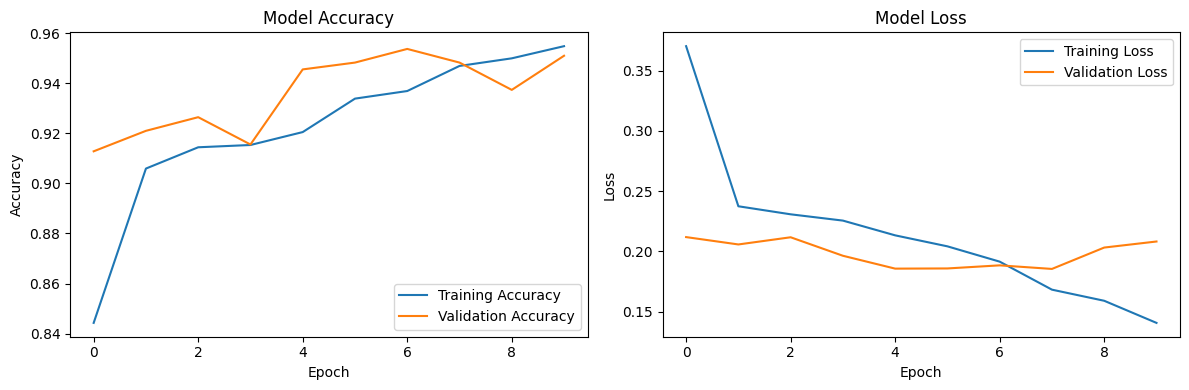

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       188
           1       0.95      0.95      0.95       179

    accuracy                           0.95       367
   macro avg       0.95      0.95      0.95       367
weighted avg       0.95      0.95      0.95       367



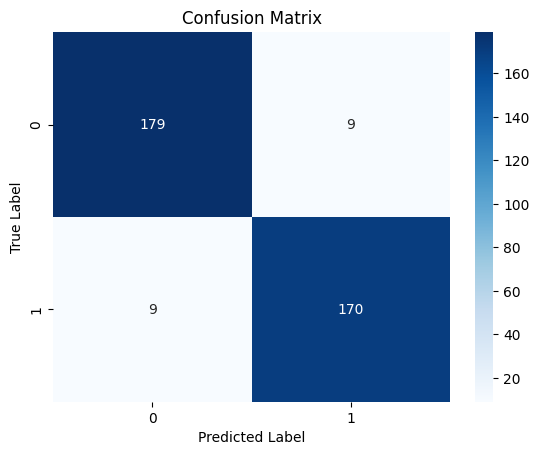

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()